<a href="https://colab.research.google.com/github/hadeyema/playground-6psrqy2u/blob/master/CopieP5Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install -q kmodes
!pip install pycodestyle
!pip install pycodestyle_magic
!pip install flake8
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from kmodes.kmodes import KModes
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram

In [43]:
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

In [44]:
data = pd.read_csv('/content/data_cleaned.csv')

In [45]:
data.shape

(116592, 23)

#**RFM**

In [46]:
# Distribution of customers by city of Brazil
distribution = data[['customer_city', 'customer_unique_id']].\
                groupby(['customer_city']).\
                agg({'customer_unique_id': lambda x: x.nunique()}).\
                reset_index().sort_values('customer_unique_id',
                                          ascending=False)

distribution.rename(columns={'customer_unique_id': 'nombre clients'},
                    inplace=True)
distribution.head()

,customer_city,nombre clients
3576,sao paulo,14636
3136,rio de janeiro,6471
451,belo horizonte,2609
556,brasilia,2027
1139,curitiba,1440


In [47]:
distribution['nombre clients'].sum()

94214

In [48]:
def unique_counts(df):
    """ Returns the unique number of value per variable. """
    for i in df.columns:
        count = df[i].nunique()
        print("%s : %d" % (i, count))


unique_counts(data)

Unnamed: 0 : 116592
customer_id : 97263
customer_unique_id : 94095
customer_zip_code_prefix : 14927
customer_city : 4095
customer_state : 27
order_id : 97263
order_purchase_timestamp : 96728
order_approved_at : 88975
order_item_id : 21
product_id : 32338
seller_id : 3035
price : 5902
product_category_name : 73
review_id : 97061
review_score : 5
payment_sequential : 29
payment_type : 4
payment_installments : 24
payment_value : 28769
seller_zip_code_prefix : 2211
seller_city : 604
seller_state : 23


In [49]:
# Search for the earliest date
ancien = data["order_purchase_timestamp"].min()
ancien

'2016-09-04 21:15:19'

In [50]:
# search for the most recent date
recent = data["order_purchase_timestamp"].max()
recent

'2018-09-03 09:06:57'

In [51]:
import datetime as dt
aammjj = str.split(str.split(recent)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]) + 1)

In [52]:
# Type of "order_purchase_timestamp" to datetime
data["order_purchase_timestamp"] = pd.\
    to_datetime(data["order_purchase_timestamp"])

In [53]:
# Set up the RFM table

# Recency: number of days elapsed since last purchase

# Frequency: the number of times the customer has made a purchase

# Monetary: the total amount spent by a client
rfmTable = data.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "order_id": lambda x: x.nunique(),
                 "price": lambda x: sum(x)})

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency',
                         'order_id': 'frequency',
                         'price': 'monetary_value'}, inplace=True)

In [54]:
rfmTable.head(10)

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00
00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99
00053a61a98854899e70ed204dd4bafe,187,1,382.00
0005e1862207bf6ccc02e4228effd9a0,548,1,135.00


In [55]:
rfmTable.shape

(94095, 3)

In [56]:
rfmTable.columns

Index(['recency', 'frequency', 'monetary_value'], dtype='object')

In [57]:
quartiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])  # Quartile
print(quartiles)

      recency  frequency  monetary_value
0.25    119.0        1.0            48.9
0.50    223.0        1.0            89.9
0.75    352.0        1.0           159.9


In [58]:
quartiles = quartiles.to_dict()    # Trsnformation dataframe to dictionary
quartiles

{'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 48.9, 0.5: 89.9, 0.75: 159.9},
 'recency': {0.25: 119.0, 0.5: 223.0, 0.75: 352.0}}

In [59]:
segmented_rfm = rfmTable.copy()

In [60]:
def RScore(x, p, d):
    """Returns the recent score for a value relative to quartile value"""
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FMScore(x, p, d):
    """
        Returns the frequency and monetary score
        to quartile value
    """
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [61]:
# Table RFM with score
segmented_rfm['r_quartile'] = segmented_rfm['recency'].\
    apply(RScore, args=('recency', quartiles))

segmented_rfm['f_quartile'] = segmented_rfm['frequency'].\
    apply(FMScore, args=('frequency', quartiles))

segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].\
    apply(FMScore, args=('monetary_value', quartiles))

segmented_rfm['RFMScore'] = (segmented_rfm["r_quartile"].astype(str) + "-").\
                    str.cat(segmented_rfm["f_quartile"].astype(str) + "-").\
                    str.cat(segmented_rfm["m_quartile"].astype(str))

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,4,2,1-4-2
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,4,4,1-4-4
0000f46a3911fa3c0805444483337064,542,1,69.00,4,4,3,4-4-3
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,3,4,4,3-4-4
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,4,1,3-4-1


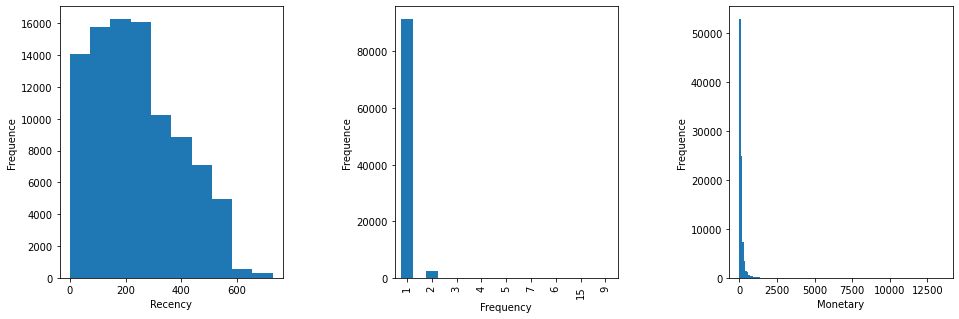

In [62]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins


r = segmented_rfm['recency']
m = segmented_rfm['monetary_value']

plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=0.5)

# Recency
plt.subplot(131)
plt.xlabel('Recency')
plt.ylabel('Frequence')
counts, bins = np.histogram(r)
plt.hist(bins[:-1], bins, weights=counts)

# Frequency
plt.subplot(132)
plt.xlabel('Frequency')
plt.ylabel('Frequence')
segmented_rfm['frequency'].value_counts().plot(kind="bar", width=0.5)

# Monetary
plt.subplot(133)
plt.xlabel('Monetary')
plt.ylabel('Frequence')
bins = compute_histogram_bins(m, 100)
plt.hist(m, bins=bins)

plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f1200f09790>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1201d9b350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1201f9ce90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1201d9b450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1200f097d0>,
  <matplotlib.lines.Line2D at 0x7f1200f09410>]}

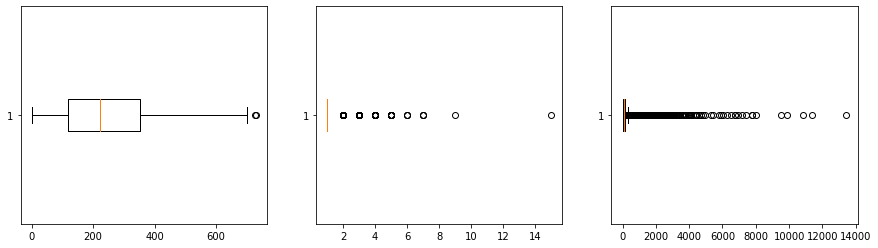

In [63]:
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.boxplot(segmented_rfm["recency"], vert=False)

ax = fig.add_subplot(132)
ax.boxplot(segmented_rfm["frequency"], vert=False)

ax = fig.add_subplot(133)
ax.boxplot(segmented_rfm["monetary_value"], vert=False)

In [64]:
segmented_rfm['RFMScore'].unique()

array(['1-4-2', '1-4-4', '4-4-3', '3-4-4', '3-4-1', '2-4-2', '2-4-4',
       '2-4-1', '4-4-2', '4-4-4', '3-4-3', '2-4-3', '4-4-1', '1-4-1',
       '3-4-2', '1-4-3', '3-1-1', '1-1-3', '2-1-1', '4-1-1', '1-1-1',
       '2-1-4', '4-1-3', '3-1-2', '1-1-2', '3-1-3', '1-1-4', '2-1-3',
       '2-1-2', '4-1-4', '4-1-2', '3-1-4'], dtype=object)

In [65]:
mean_var = segmented_rfm.groupby("RFMScore")[
    ["recency", "frequency", "monetary_value"]].\
    agg([np.mean, np.var])

mean_var["size"] = segmented_rfm.groupby('RFMScore')[['recency']].\
    agg([np.size])

mean_var

recency              frequency           monetary_value  \
                mean          var      mean       var           mean   
RFMScore                                                               
1-1-1      63.745935  1101.053446  2.235772  0.706009     414.187622   
1-1-2      62.250000  1100.085897  2.030612  0.029827     125.925561   
1-1-3      66.152174  1101.339226  2.043478  0.042045      71.124891   
1-1-4      63.458333  1405.302536  2.000000  0.000000      37.651250   
1-4-1      63.524612  1096.214997  1.000000  0.000000     390.383184   
1-4-2      63.652942  1115.531415  1.000000  0.000000     121.226533   
1-4-3      60.751591  1124.471439  1.000000  0.000000      66.975896   
1-4-4      61.541639  1123.933205  1.000000  0.000000      29.810774   
2-1-1     174.516327   895.219569  2.169388  0.378202     379.413735   
2-1-2     171.274854   907.624011  2.064327  0.060544     124.434327   
2-1-3     172.792683  1010.833032  2.012195  0.012195      71.754512   
2-1-4     164.409091   825.967532  2.000000  0.000000      34.343636   
2-4-1     170.258028   898.018683  1.000000  0.000000     366.617793   
2-4-2     169.754978   921.648129  1.000000  0.000000     122.067676   
2-4-3     171.079616   900.319617  1.000000  0.000000      67.180156   
2-4-4     172.753999   861.611585  1.000000  0.000000      29.877048   
3-1-1     283.752294  1362.485627  2.110092  0.134978     424.325986   
3-1-2     281.685185  1251.794686  2.012346  0.012269     123.662593   
3-1-3     286.868421  1112.515789  2.000000  0.000000      70.637237   
3-1-4     287.000000  1210.555556  2.052632  0.052632      42.483158   
3-4-1     282.861423  1239.695499  1.000000  0.000000     365.554122   
3-4-2     282.926058  1248.644132  1.000000  0.000000     121.501658   
3-4-3     281.715170  1244.060319  1.000000  0.000000      67.173487   
3-4-4     281.352806  1250.617430  1.000000  0.000000      29.545575   
4-1-1     439.673352  4375.801041  2.080229  0.079752     449.294212   
4-1-2     444.402778  4379.738733  2.048611  0.046571     125.825417   
4-1-3     461.875000  4309.285714  2.109375  0.321181      71.187500   
4-1-4     482.100000  7156.024138  2.166667  0.212644      33.106000   
4-4-1     460.195994  5444.051724  1.000000  0.000000     392.707250   
4-4-2     457.909695  5043.218788  1.000000  0.000000     120.322216   
4-4-3     452.450297  4992.110163  1.000000  0.000000      67.322725   
4-4-4     460.423726  5080.939245  1.000000  0.000000      29.460204   

                         size  
                    var        
RFMScore                       
1-1-1     129261.507860   492  
1-1-2        413.205307   196  
1-1-3        126.361190    92  
1-1-4         72.390403    24  
1-4-1     197537.528494  5343  
1-4-2        389.709788  5999  
1-4-3        148.932283  5656  
1-4-4        112.102013  5980  
2-1-1      89125.722919   490  
2-1-2        384.734431   171  
2-1-3        142.357124    82  
2-1-4         70.922481    22  
2-4-1     134605.400161  5325  
2-4-2        401.997439  5775  
2-4-3        162.897907  5514  
2-4-4        112.178922  5939  
3-1-1     138485.014530   436  
3-1-2        397.149209   162  
3-1-3        154.224372    76  
3-1-4         58.474601    19  
3-4-1     139337.226866  5441  
3-4-2        417.403571  5626  
3-4-3        170.816712  6137  
3-4-4        109.191327  5666  
4-1-1     370025.199368   349  
4-1-2        370.104905   144  
4-1-3        144.071178    64  
4-1-4         69.043832    30  
4-4-1     222004.982478  5592  
4-4-2        384.225929  5271  
4-4-3        166.117767  6056  
4-4-4        115.830423  5926

In [66]:
# Contingency table
# Recency X frequency, Recency X Monetary_value, Frequency X Monetary_value
RF = pd.DataFrame(columns=['1', '2', '3', '4'])
RM = pd.DataFrame(columns=['1', '2', '3', '4'])
FM = pd.DataFrame(columns=['1', '2', '3', '4'])
size = segmented_rfm.shape[0]
for i in range(1, 5):
    row_crf = []
    row_crm = []
    row_cfm = []
    for j in range(1, 5):
        crf = 0
        crm = 0
        cfm = 0
        for k, row in segmented_rfm.iterrows():
            if row["r_quartile"] == i and row["f_quartile"] == j:
                crf += 1
            if row["r_quartile"] == i and row["m_quartile"] == j:
                crm += 1
            if row["f_quartile"] == i and row["m_quartile"] == j:
                cfm += 1
        row_crf.append(crf)
        row_crm.append(crm)
        row_cfm.append(cfm)
    RF.loc[i] = row_crf
    RM.loc[i] = row_crm
    FM.loc[i] = row_cfm

In [67]:
RF.style.set_caption("Recency X Frequency")
RF

,1,2,3,4
1,804,0,0,22978
2,765,0,0,22553
3,693,0,0,22870
4,587,0,0,22845


In [68]:
RM.style.set_caption("Recency X Monetary")
RM

,1,2,3,4
1,5835,6195,5748,6004
2,5815,5946,5596,5961
3,5877,5788,6213,5685
4,5941,5415,6120,5956


In [69]:
FM.style.set_caption("frequency X Monetary")
FM

,1,2,3,4
1,1767,673,314,95
2,0,0,0,0
3,0,0,0,0
4,21701,22671,23363,23511


In [70]:
customer_segment = pd.DataFrame()
segment = ["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost",
           "Lost Customers", "Lost Cheap Customers", "Autres"
          ]
rfm = ["1-1-1", "X-1-X", "X-X-1", "3-1-1", "4-1-1", "4-4-4", "Autres"]
description = ["Les clients qui ont acheté le plus récemment, le plus souvent \
               et qui dépensent le plus.",
               "Les clients ayant acheté le plus récemment",
               "Les clients qui dépensent le plus",
               "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
               et ont dépensé le plus.",
               "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont \
               dépensé le plus.",
               "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
               ""
              ]
marketing = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
             "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
             "Commercialisez vos produits les plus chers.",
             "Offrez d'autres produits pertinents et des rabais spéciaux.",
             "Incitations à des prix agressifs",
             "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             "Ajuster les intervales pour le réduire si important"
            ]
customer_segment["rfm"] = rfm
customer_segment["segments clients"] = segment

In [71]:
sums = []
X1X = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4"]
XX1 = ["1-2-1", "1-3-1", "1-4-1", "2-2-1", "2-3-1", "2-4-1"]
for r in rfm:
    count = 0
    if r == "X-1-X":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in X1X:
                count += 1
        sums.append(count)
    if r == "X-X-1":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in XX1 and r != "2-1-1":
                count += 1
        sums.append(count)
    if r != "X-1-X" and r != "X-X-1" and r != "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] == r:
                count += 1
        sums.append(count)
    if r == "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] not in rfm and row["RFMScore"] not in X1X and \
            row["RFMScore"] not in XX1:
                count += 1
        sums.append(count)
        
customer_segment["nombre de clients"] = sums

In [72]:
customer_segment["activité"] = description
customer_segment["Conseil d'action"] = marketing

# Customer/segment
customer_segment

,rfm,segments clients,nombre de clients,activité,Conseil d'action
0,1-1-1,Best Customers,492,"Les clients qui ont acheté le plus récemment, ...","Pas d'incitation aux prix, Nouveaux produits e..."
1,X-1-X,Loyal Customers,1077,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Dem...
2,X-X-1,Big Spenders,10668,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
3,3-1-1,Almost Lost,436,"N'ont pas acheté depuis un certain temps, mais...",Offrez d'autres produits pertinents et des rab...
4,4-1-1,Lost Customers,349,"N'ont pas acheté depuis longtemps, mais ont ac...",Incitations à des prix agressifs
5,4-4-4,Lost Cheap Customers,5926,"Dernier achat il y a longtemps, acheté peu et ...",Ne passez pas trop de temps à essayer de vous ...
6,Autres,Autres,75147,,Ajuster les intervales pour le réduire si impo...


In [73]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers", "Autres"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
                ""
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
              "Ajuster les intervales pour le réduire si important"
             ]
customer_segment_["segment"] = segment_

In [74]:
recents_ = []
def countCustomerSegment(segmented_rfmp):
    """Main function is to return the customer identities for each segment"""
    seg_cus_id = {"Best Customers": [], "Loyal Customers": [], "Promissing": [],
                  "Big Spenders": [],"Almost Lost": [], "Lost Customers": [],
                  "Lost Cheap Customers": [], "Autres": []}
    sums_ = []
    best = ["1-1-1"]
    X1X_ = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4", "1-4-2", "2-4-2"]
    promiss = ["1-4-3", "1-4-4", "2-4-3", "2-4-4"]
    XX1_ = ["1-2-1", "1-3-1", "1-4-1", "2-3-1", "2-4-1"]
    almost_lost = ["3-1-1", "3-4-1", "3-4-2"]
    lost = ["3-4-3", "3-4-4", "4-1-1", "4-4-1", "4-4-2"]
    lost_cheap = ["4-4-4", "4-4-3"]
    for s in segment_:
        count = 0
        rec = 0
        if s == "Best Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in best:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Loyal Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in X1X_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Promissing":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in promiss:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Big Spenders":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in XX1_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Almost Lost":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in almost_lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Cheap Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Autres":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] not in best and row["RFMScore"] not in X1X_ \
                and row["RFMScore"] not in XX1_ and row["RFMScore"] not in promiss and \
                row["RFMScore"] not in lost and row["RFMScore"] not in almost_lost and \
                row["RFMScore"] not in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
                    
        sums_.append(count)
        recents_.append(int(rec/count))
        
    return (seg_cus_id,sums_)

In [75]:
cus_id, customer_segment_["nombre de clients"] = countCustomerSegment(segmented_rfm)
customer_segment_["description"] = description_
customer_segment_["marketing"] = marketing_

#customer/segment
customer_segment_

,segment,nombre de clients,description,marketing
0,Best Customers,492,"Les clients qui ont acheté le plus récemment, ...","Pas d'incitation aux prix, Nouveaux produits e..."
1,Loyal Customers,12851,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Dem...
2,Promissing,23089,"Des acheteurs récents, mais qui n'ont pas beau...",offrir des essais gratuits
3,Big Spenders,10668,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
4,Almost Lost,11503,"N'ont pas acheté depuis un certain temps, mais...",Offrez d'autres produits pertinents et des rab...
5,Lost Customers,23015,"N'ont pas acheté depuis longtemps, mais ont ac...",Incitations à des prix agressifs
6,Lost Cheap Customers,11982,"Dernier achat il y a longtemps, acheté peu et ...",Ne passez pas trop de temps à essayer de vous ...
7,Autres,495,,Ajuster les intervales pour le réduire si impo...


Text(0, 0.5, 'Nombre de clients par segments')

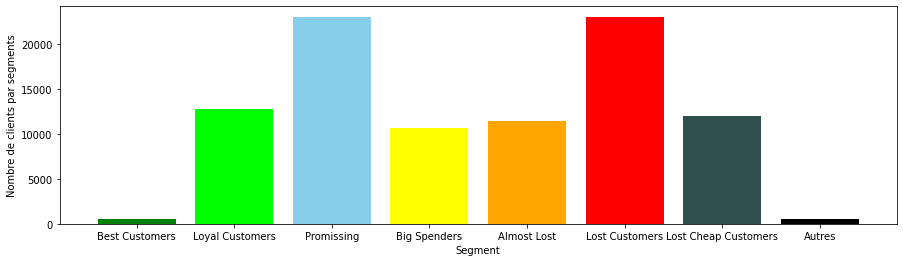

In [76]:
plt.figure(figsize=(15, 4))
plt.bar(customer_segment_["segment"], customer_segment_["nombre de clients"], align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange", "red", "#2F4F4F", "black"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

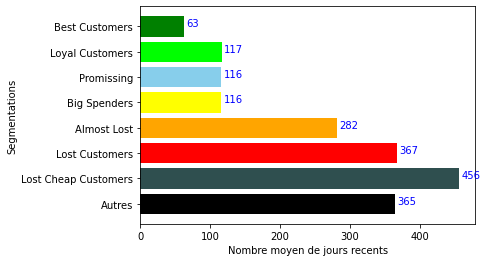

In [77]:
fig, ax = plt.subplots() 
ax.barh(customer_segment_["segment"].iloc[::-1] , recents_[::-1],
        color=["black", "#2F4F4F", "red", "orange", "yellow","#87ceeb", "lime", "green"]
       )
plt.xlabel('Nombre moyen de jours recents')
plt.ylabel('Segmentations')
for i, v in enumerate(recents_[::-1]):
    ax.text(v + 3, i + .0, str(v), color='blue')

In [78]:
XRFM = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
segments_labels = []
for i, row in XRFM.iterrows():
    if i in cus_id["Best Customers"]:
        segments_labels.append("Best Customers")
        continue
    if i in cus_id["Loyal Customers"]:
        segments_labels.append("Loyal Customers")
        continue
    if i in cus_id["Promissing"]:
        segments_labels.append("Promissing")
        continue
    if i in cus_id["Big Spenders"]:
        segments_labels.append("Big Spenders")
        continue
    if i in cus_id["Almost Lost"]:
        segments_labels.append("Almost Lost")
        continue
    if i in cus_id["Lost Customers"]:
        segments_labels.append("Lost Customers")
        continue
    if i in cus_id["Lost Cheap Customers"]:
        segments_labels.append("Lost Cheap Customers")
        continue
    if i in cus_id["Autres"]:
        segments_labels.append("Autres")
        continue

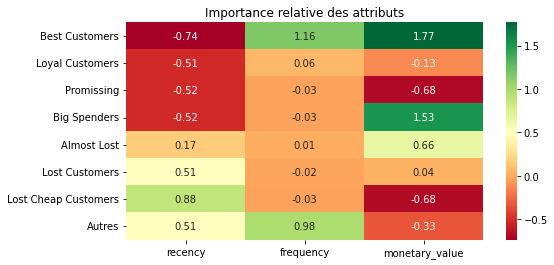

In [79]:
relative_imp_sort = pd.DataFrame()
XRFM["segment_appartenance"] = segments_labels

population = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
population_avg = population.mean()

cluster_avg = XRFM.groupby(['segment_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1

relative_imp_sort["Best Customers"] = relative_imp.loc["Best Customers"]
relative_imp_sort["Loyal Customers"] = relative_imp.loc["Loyal Customers"]
relative_imp_sort["Promissing"] = relative_imp.loc["Promissing"]
relative_imp_sort["Big Spenders"] = relative_imp.loc["Big Spenders"]
relative_imp_sort["Almost Lost"] = relative_imp.loc["Almost Lost"]
relative_imp_sort["Lost Customers"] = relative_imp.loc["Lost Customers"]
relative_imp_sort["Lost Cheap Customers"] = relative_imp.loc["Lost Cheap Customers"]
relative_imp_sort["Autres"] = relative_imp.loc["Autres"]

plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp_sort.T, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

#**Maintenance**

In [80]:
# Retrieve the last three months
past = {}
for i in range(0, 4):
    past[i] = dt.datetime(int(aammjj[0]), int(aammjj[1])-i, int(aammjj[2]))
past

{0: datetime.datetime(2018, 9, 3, 0, 0),
 1: datetime.datetime(2018, 8, 3, 0, 0),
 2: datetime.datetime(2018, 7, 3, 0, 0),
 3: datetime.datetime(2018, 6, 3, 0, 0)}

In [81]:
customerPast = data[data["order_purchase_timestamp"] < past[3]]
customer_retain = customerPast["customer_unique_id"].unique()

In [82]:
dist = {}
cus_id_list = {}
dict_rfmTable = {}
for i in range(0, 4):
    customerPast = data[data["order_purchase_timestamp"] < past[i]]
    customerPast = customerPast[customerPast["customer_unique_id"].isin(list(customer_retain))]
    rfmTablePast = customerPast.groupby('customer_unique_id').\
                    agg({"order_purchase_timestamp": lambda x: (past[i] - x.max()).days,
                         "price": lambda x: sum(x)})

    rfmTablePast['order_purchase_timestamp'] = rfmTablePast['order_purchase_timestamp'].astype(int)
    rfmTablePast.rename(columns={'order_purchase_timestamp': 'recency',
                                 'price': 'monetary_value'
                                }, inplace=True)
    
    '''
    Calcul of number of orders by customer
    '''
    dd = customerPast.groupby(['customer_unique_id', 'order_id']).\
                   agg({"customer_unique_id": lambda x: 0})

    freq = []
    for index in list(rfmTablePast.index):
        freq.append(dd.loc[[index]].shape[0])
    
    rfmTablePast['frequency'] = freq

    cols = ['recency', 'frequency', 'monetary_value'] 
    rfmTablePast = rfmTablePast[cols]
    
    
    quartilesPast = rfmTablePast.quantile(q=[0.25, 0.5, 0.75])
    quartilesPast = quartilesPast.to_dict()  # Transformation dataframe en dictionnaire

    rfmTablePast['r_quartile'] = rfmTablePast['recency'].\
        apply(RScore, args=('recency', quartilesPast))
    rfmTablePast['f_quartile'] = rfmTablePast['frequency'].\
        apply(FMScore, args=('frequency', quartilesPast))
    rfmTablePast['m_quartile'] = rfmTablePast['monetary_value']. \
        apply(FMScore, args=('monetary_value', quartilesPast))

    rfmTablePast['RFMScore'] = (rfmTablePast["r_quartile"].astype(str) + "-").\
                                str.cat(rfmTablePast["f_quartile"].astype(str) + "-").\
                                str.cat(rfmTablePast["m_quartile"].astype(str))
    
    cus_id_list[i], dist[i] = countCustomerSegment(rfmTablePast)
    dict_rfmTable[i] = rfmTablePast.copy()
dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{0: [626, 10447, 18603, 8538, 9258, 18689, 9696, 405],
 1: [566, 10418, 18630, 8551, 9274, 18708, 9709, 406],
 2: [490, 10420, 18804, 8665, 9195, 18609, 9673, 406],
 3: [379, 10383, 18860, 8692, 9211, 18646, 9684, 407]}

In [83]:
# Construct matching indices between source and target
s = []
t = []
for i in range(0, 24):
    for j in range(0, 8):
        s.append(i)
    if i in range(0, 8):
        for k in range(8, 16):
            t.append(k)
    if i in range(8, 16):
        for k in range(16, 24):
            t.append(k)
    if i in range(16, 24):
        for k in range(24, 32):
            t.append(k)

In [84]:
# Construct the values between the sources and the targets
v = []
m_v = {}
for i in range(3, 0, -1):
    m = []
    for j in range(0, 8):
        line = []
        for k in range(0, 8):
            nb_int = len(set(cus_id_list[i][segment_[j]]) &
                         set(cus_id_list[i-1][segment_[k]]))
            v.append(nb_int)
            line.append(nb_int)
        m.append(line)
    m_v[i] = m

In [85]:
# Set up labels and colors
ls = []
c = []
labels_set = ["Best Customers", "Loyal Customers", "Promissing",
              "Big Spenders", "Almost Lost", "Lost Customers",
              "Lost Cheap Customers", "Autres"]
colors_set = ["green", "lime", "#87ceeb", "yellow", "orange",
              "red", "#2F4F4F", "black"]

for i in range(1, 5):
    for j in range(0, 8):
        ls.append(labels_set[j] + str(i))
        c.append(colors_set[j])

In [86]:
# Display Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20,
                line=dict(color ="black", width=0.5),
                label=ls, color = c
               ),
    link=dict(source=s, target=t, value=v)
    )])

fig.update_layout(title_text="Diagramme de flux de clients entre segments",
                  font_size=10)
fig.show()

In [87]:
values1 = pd.DataFrame(m_v[3])  # (2018, 6, 3, 0, 0) to (2018, 7, 3, 0, 0)
values1 = values1.rename(index={0: "Best Customers (2018, 6, 3)",
                                1: "Loyal Customers (2018, 6, 3)",
                                2: "Promissing (2018, 6, 3)",
                                3: "Big Spenders (2018, 6, 3)",
                                4: "Almost Lost (2018, 6, 3)",
                                5: "Lost Customers (2018, 6, 3)",
                                6: "Lost Cheap (2018, 6, 3)",
                                7: "Autres (2018, 6, 3)"
                               },
                         columns={0: "Best Customers (2018, 7, 3)",
                                  1: "Loyal Customers (2018, 7, 3)",
                                  2: "Promissing (2018, 7, 3)",
                                  3: "Big Spenders (2018, 7, 3)",
                                  4: "Almost Lost (2018, 7, 3)",
                                  5: "Lost Customers (2018, 7, 3)",
                                  6: "Lost Cheap (2018, 7, 3)",
                                  7: "Autres (2018, 7, 3)"
                                 }
                        )
values1

,"Best Customers (2018, 7, 3)","Loyal Customers (2018, 7, 3)","Promissing (2018, 7, 3)","Big Spenders (2018, 7, 3)","Almost Lost (2018, 7, 3)","Lost Customers (2018, 7, 3)","Lost Cheap (2018, 7, 3)","Autres (2018, 7, 3)"
"Best Customers (2018, 6, 3)",379,0,0,0,0,0,0,0
"Loyal Customers (2018, 6, 3)",25,10358,0,0,0,0,0,0
"Promissing (2018, 6, 3)",20,36,18804,0,0,0,0,0
"Big Spenders (2018, 6, 3)",27,0,0,8665,0,0,0,0
"Almost Lost (2018, 6, 3)",13,3,0,0,9195,0,0,0
"Lost Customers (2018, 6, 3)",22,15,0,0,0,18609,0,0
"Lost Cheap (2018, 6, 3)",4,7,0,0,0,0,9673,0
"Autres (2018, 6, 3)",0,1,0,0,0,0,0,406


In [88]:
values2 = pd.DataFrame(m_v[2])  # (2018, 7, 3, 0, 0) to (2018, 8, 3, 0, 0)
values2 = values2.rename(index={0: "Best Customers (2018, 7, 3)",
                                1: "Loyal Customers (2018, 7, 3)",
                                2: "Promissing (2018, 7, 3)",
                                3: "Big Spenders (2018, 7, 3)",
                                4: "Almost Lost (2018, 7, 3)",
                                5: "Lost Customers (2018, 7, 3)",
                                6: "Lost Cheap (2018, 7, 3)",
                                7: "Autres (2018, 7, 3)"
                               },
                         columns={0: "Best Customers (2018, 8, 3)",
                                  1: "Loyal Customers (2018, 8, 3)",
                                  2: "Promissing (2018, 8, 3)",
                                  3: "Big Spenders (2018, 8, 3)",
                                  4: "Almost Lost (2018, 8, 3)",
                                  5: "Lost Customers (2018, 8, 3)",
                                  6: "Lost Cheap (2018, 8, 3)",
                                  7: "Autres (2018, 8, 3)"
                                 }
                        )
values2

,"Best Customers (2018, 8, 3)","Loyal Customers (2018, 8, 3)","Promissing (2018, 8, 3)","Big Spenders (2018, 8, 3)","Almost Lost (2018, 8, 3)","Lost Customers (2018, 8, 3)","Lost Cheap (2018, 8, 3)","Autres (2018, 8, 3)"
"Best Customers (2018, 7, 3)",489,1,0,0,0,0,0,0
"Loyal Customers (2018, 7, 3)",16,10328,0,0,76,0,0,0
"Promissing (2018, 7, 3)",15,28,18630,0,0,131,0,0
"Big Spenders (2018, 7, 3)",18,40,0,8551,56,0,0,0
"Almost Lost (2018, 7, 3)",14,1,0,0,9142,38,0,0
"Lost Customers (2018, 7, 3)",12,11,0,0,0,18539,47,0
"Lost Cheap (2018, 7, 3)",2,9,0,0,0,0,9662,0
"Autres (2018, 7, 3)",0,0,0,0,0,0,0,406


In [89]:
values3 = pd.DataFrame(m_v[1])  # (2018, 8, 3, 0, 0) to (2018, 9, 3, 0, 0)
values3 = values3.rename(index={0: "Best Customers (2018, 8, 3)",
                                1: "Loyal Customers (2018, 8, 3)",
                                2: "Promissing (2018, 8, 3)",
                                3: "Big Spenders (2018, 8, 3)",
                                4: "Almost Lost (2018, 8, 3)",
                                5: "Lost Customers (2018, 8, 3)",
                                6: "Lost Cheap (2018, 8, 3)",
                                7: "Autres (2018, 8, 3)"
                               },
                         columns={0: "Best Customers (2018, 9, 3)",
                                  1: "Loyal Customers (2018, 9, 3)",
                                  2: "Promissing (2018, 9, 3)",
                                  3: "Big Spenders (2018, 9, 3)",
                                  4: "Almost Lost (2018, 9, 3)",
                                  5: "Lost Customers (2018, 9, 3)",
                                  6: "Lost Cheap (2018, 9, 3)",
                                  7: "Autres (2018, 9, 3)"
                                 }
                        )
values3

,"Best Customers (2018, 9, 3)","Loyal Customers (2018, 9, 3)","Promissing (2018, 9, 3)","Big Spenders (2018, 9, 3)","Almost Lost (2018, 9, 3)","Lost Customers (2018, 9, 3)","Lost Cheap (2018, 9, 3)","Autres (2018, 9, 3)"
"Best Customers (2018, 8, 3)",560,6,0,0,0,0,0,0
"Loyal Customers (2018, 8, 3)",13,10405,0,0,0,0,0,0
"Promissing (2018, 8, 3)",4,23,18603,0,0,0,0,0
"Big Spenders (2018, 8, 3)",13,0,0,8538,0,0,0,0
"Almost Lost (2018, 8, 3)",16,0,0,0,9258,0,0,0
"Lost Customers (2018, 8, 3)",15,4,0,0,0,18689,0,0
"Lost Cheap (2018, 8, 3)",4,9,0,0,0,0,9696,0
"Autres (2018, 8, 3)",1,0,0,0,0,0,0,405


In [90]:
for i in range(1, 0, -1):  # Last month: (2018, 8, 3) to (2018, 9, 3)
    id_list = []
    for j in range(0, 1):  # Best Customers, Loyal Customers
        for k in range(4, 7):  # Almost Lost, Lost, Lost Cheap
            temp = list(set(cus_id_list[i][segment_[k]]) &
                        set(cus_id_list[i-1][segment_[j]]))
            for m in temp:
                id_list.append(m)
    df1 = dict_rfmTable[i][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df1 = df1.rename(columns={"recency": "recency (2018, 8, 3)",
                              "frequency": "frequency (2018, 8, 3)",
                              "monetary_value": "monetary_value (2018, 8, 3)",
                              "RFMScore": "RFMScore (2018, 8, 3)"
                             }
                    )
    df2 = dict_rfmTable[i-1][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df2 = df2.rename(columns={"recency": "recency (2018, 9, 3)",
                              "frequency": "frequency (2018, 9, 3)",
                              "monetary_value": "monetary_value (2018, 9, 3)",
                              "RFMScore": "RFMScore (2018, 9, 3)"
                             }
                    )

    df = pd.concat([df1, df2], axis=1, sort=False)

In [91]:
df[23:33]

,"recency (2018, 8, 3)","frequency (2018, 8, 3)","monetary_value (2018, 8, 3)","RFMScore (2018, 8, 3)","recency (2018, 9, 3)","frequency (2018, 9, 3)","monetary_value (2018, 9, 3)","RFMScore (2018, 9, 3)"
customer_unique_id,,,,,,,,
d08c29302907086e8fe823369542f3ae,383,1,388.98,4-4-1,10,2,418.78,1-1-1
3fe3e628c6c7a15ae96416826a4c5952,374,1,119.99,4-4-2,15,2,368.99,1-1-1
0ef7b906320b21fe4d39f99496aaa2d8,442,1,99.99,4-4-2,29,2,169.98,1-1-1
423d40b193638955a782839886648464,467,1,198.00,4-4-1,26,2,917.90,1-1-1
130f4a32887cc549621b3c6cf36bf77e,277,1,89.90,3-4-3,16,2,189.80,1-1-1
71a92fd3087501bcfba6e6e1ef7e8fd7,449,1,198.00,4-4-1,23,2,248.00,1-1-1
97258e1c1f77f32358eccd1c9ee5954d,496,1,139.99,4-4-2,22,2,249.99,1-1-1
f1c08d13b8520a6efa197627fada3a56,282,1,62.70,3-4-3,27,2,162.70,1-1-1
ee04cc9bca4c9198bec5c54c2542dd3b,408,1,79.90,4-4-3,27,2,206.89,1-1-1


# KModes algorithm

In [92]:
grouped = data[['customer_unique_id', 'product_category_name']].\
    groupby('customer_unique_id')

In [93]:
cus_prod = {}
for name, group in grouped:
    cus_prod[name] = list(set(group["product_category_name"].values))

In [94]:
cus_prod

{'0000366f3b9a7992bf8c76cfdf3221e2': ['bed_bath_table'],
 '0000b849f77a49e4a4ce2b2a4ca5be3f': ['health_beauty'],
 '0000f46a3911fa3c0805444483337064': ['stationery'],
 '0000f6ccb0745a6a4b88665a16c9f078': ['telephony'],
 '0004aac84e0df4da2b147fca70cf8255': ['telephony'],
 '0004bd2a26a76fe21f786e4fbd80607f': ['garden_tools'],
 '00050ab1314c0e55a6ca13cf7181fecf': ['telephony'],
 '00053a61a98854899e70ed204dd4bafe': ['sports_leisure'],
 '0005e1862207bf6ccc02e4228effd9a0': ['fashion_bags_accessories'],
 '0005ef4cd20d2893f0d9fbd94d3c0d97': ['sports_leisure'],
 '0006fdc98a402fceb4eb0ee528f6a8d4': ['bed_bath_table'],
 '00082cbe03e478190aadbea78542e933': ['luggage_accessories'],
 '00090324bbad0e9342388303bb71ba0a': ['bed_bath_table'],
 '000949456b182f53c18b68d6babc79c1': ['computers_accessories'],
 '000a5ad9c4601d2bbdd9ed765d5213b3': ['health_beauty'],
 '000bfa1d2f1a41876493be685390d6d3': ['fashion_bags_accessories'],
 '000c8bdb58a29e7115cfc257230fb21b': ['bed_bath_table'],
 '000d460961d6dbfa3ec6

In [95]:
colname_indice = {}
i = 0
for cat in data["product_category_name"].unique():
    colname_indice[cat] = i
    i += 1

In [96]:
OH_cols = pd.DataFrame(columns=list(data["product_category_name"].unique()))
OH_cols

,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine


In [97]:
# It does 65 minutes
for k, v in cus_prod.items():
    row = [0]*OH_cols.shape[1]
    for cat in v:
        row[colname_indice[cat]] = 1
    OH_cols.loc[k] = row

In [ ]:
#OH_cols.to_csv("OH_cols.csv", sep=',')
OH_cols.to_csv('/content/OH_cols.csv')

In [98]:
OH_cols.head()

,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine
0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


le nombre de clusters optimal est : 14


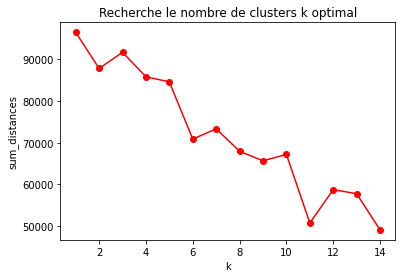

In [99]:
# Search for the optimal hyperparameter k
sum_distances = []
K = range(1, 15)
for k in K:
    km = KModes(n_clusters=k, init='random')
    km.fit_predict(OH_cols)
    sum_distances.append(km.cost_)
kk = sum_distances.index(min(sum_distances)) + 1

print("le nombre de clusters optimal est : {}".format(kk))

plt.plot(K, sum_distances, 'ro-')
plt.xlabel('k')
plt.ylabel('sum_distances')
plt.title('Recherche le nombre de clusters k optimal')

plt.show()

In [100]:
# Group related categories
km = KModes(n_clusters=kk, init='random', n_init=kk+1)
km.fit_predict(OH_cols)
kmodes = km.cluster_centroids_
shape = kmodes.shape
for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("cluster sans catégorie")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in OH_cols.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
cluster sans catégorie

cluster 1: 
telephony

cluster 2: 
watches_gifts

cluster 3: 
home_construction

cluster 4: 
computers_accessories

cluster 5: 
health_beauty

cluster 6: 
sports_leisure

cluster 7: 
stationery

cluster 8: 
bed_bath_table

cluster 9: 
watches_gifts
health_beauty

cluster 10: 
office_furniture

cluster 11: 
cool_stuff

cluster 12: 
housewares

cluster 13: 
furniture_decor


<BarContainer object of 14 artists>

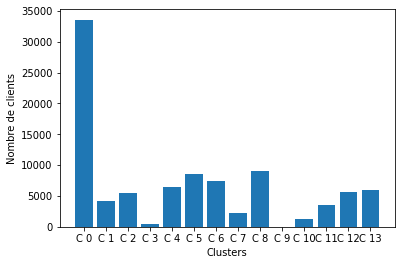

In [101]:
x = []
y = []
for i in range(0, kk):
    x.append("C " + str(i))
    y.append(np.sum(km.labels_ == i))

plt.xlabel('Clusters')
plt.ylabel('Nombre de clients')
plt.bar(x, y)

In [102]:
X = pd.concat([rfmTable, OH_cols], axis=1)

In [103]:
X.shape

(94095, 76)

In [104]:
nb_prod_by_cus = data[["customer_unique_id", "order_id"]].\
    groupby('customer_unique_id').count()

nb_prod_by_cus = nb_prod_by_cus.rename(columns={"order_id": "nb_prod_by_cus"})

In [105]:
X = pd.concat([X, nb_prod_by_cus], axis=1)

In [106]:
X.head(10)

,recency,frequency,monetary_value,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine,nb_prod_by_cus
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,542,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00053a61a98854899e70ed204dd4bafe,187,1,382.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
0005e1862207bf6ccc02e4228effd9a0,548,1,135.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [107]:
mean_score = data[['customer_unique_id', 'review_score']].\
    groupby('customer_unique_id').mean()

mean_score = mean_score.rename(columns={"review_score": "mean_score"})

In [108]:
mean_score

,mean_score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


In [109]:
X = pd.concat([X, mean_score], axis=1)

In [110]:
X.head(10)

,recency,frequency,monetary_value,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine,nb_prod_by_cus,mean_score
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
0000f46a3911fa3c0805444483337064,542,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0
0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
00050ab1314c0e55a6ca13cf7181fecf,136,1,27.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
00053a61a98854899e70ed204dd4bafe,187,1,382.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1.0
0005e1862207bf6ccc02e4228effd9a0,548,1,135.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0


In [111]:
grouped = data[['customer_unique_id', 'customer_state']].\
    groupby('customer_unique_id')

In [112]:
state_cus = {}
for name, group in grouped:
    state_cus[name] = list(set(group["customer_state"].values))

In [113]:
state_cus

{'0000366f3b9a7992bf8c76cfdf3221e2': ['SP'],
 '0000b849f77a49e4a4ce2b2a4ca5be3f': ['SP'],
 '0000f46a3911fa3c0805444483337064': ['SC'],
 '0000f6ccb0745a6a4b88665a16c9f078': ['PA'],
 '0004aac84e0df4da2b147fca70cf8255': ['SP'],
 '0004bd2a26a76fe21f786e4fbd80607f': ['SP'],
 '00050ab1314c0e55a6ca13cf7181fecf': ['SP'],
 '00053a61a98854899e70ed204dd4bafe': ['PR'],
 '0005e1862207bf6ccc02e4228effd9a0': ['RJ'],
 '0005ef4cd20d2893f0d9fbd94d3c0d97': ['MA'],
 '0006fdc98a402fceb4eb0ee528f6a8d4': ['ES'],
 '00082cbe03e478190aadbea78542e933': ['SP'],
 '00090324bbad0e9342388303bb71ba0a': ['SP'],
 '000949456b182f53c18b68d6babc79c1': ['SP'],
 '000a5ad9c4601d2bbdd9ed765d5213b3': ['RS'],
 '000bfa1d2f1a41876493be685390d6d3': ['SP'],
 '000c8bdb58a29e7115cfc257230fb21b': ['MG'],
 '000d460961d6dbfa3ec6c9f5805769e1': ['SP'],
 '000de6019bb59f34c099a907c151d855': ['SP'],
 '000e309254ab1fc5ba99dd469d36bdb4': ['GO'],
 '000ec5bff359e1c0ad76a81a45cb598f': ['SP'],
 '000ed48ceeb6f4bf8ad021a10a3c7b43': ['SP'],
 '000fbf04

In [114]:
colstate_indice = {}
i = 0
for state in data["customer_state"].unique():
    colstate_indice[state] = i
    i += 1

In [115]:
OH_cols = pd.DataFrame(columns=list(data["customer_state"].unique()))
OH_cols

,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC,AM,AP,RR


In [116]:
for k, v in state_cus.items():
    row = [0]*OH_cols.shape[1]
    for state in v:
        row[colstate_indice[state]] = 1
    OH_cols.loc[k] = row

In [117]:
OH_cols.head()

,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC,AM,AP,RR
0000366f3b9a7992bf8c76cfdf3221e2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [118]:
X = pd.concat([X, OH_cols], axis=1)

In [119]:
cus_state_nunique = dict(data["customer_state"].value_counts())

In [120]:
col_state_count = []
for k, v in state_cus.items():
    col_state_count.append(cus_state_nunique[v[0]])

In [121]:
X["nb_cus_by_state"] = col_state_count

In [122]:
X.head()

,recency,frequency,monetary_value,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC,AM,AP,RR,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49141
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49141
0000f46a3911fa3c0805444483337064,542,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4254
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1104
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49141


In [ ]:
X.to_csv('/content/OC4.csv')

# Machine Learning Algorithms


In [123]:
for f in X.columns:
    X[f] = X[f].astype(float)

In [124]:
X["monetary_value"] = np.log1p(X["monetary_value"])

In [125]:
X

,recency,frequency,monetary_value,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC,AM,AP,RR,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1.0,4.874434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49141.0
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1.0,2.990720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49141.0
0000f46a3911fa3c0805444483337064,542.0,1.0,4.248495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4254.0
0000f6ccb0745a6a4b88665a16c9f078,326.0,1.0,3.295466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1104.0
0004aac84e0df4da2b147fca70cf8255,293.0,1.0,5.198497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [126]:
# To scale the features
# X = segmented_rfm[["recency", "frequency", "monetary_value"]]

X_scale = preprocessing.StandardScaler().fit_transform(X)

In [127]:
X_scale = pd.DataFrame(X_scale, index=list(X.index), columns=X.columns)

In [128]:
X_scale.head()

,recency,frequency,monetary_value,office_furniture,furniture_decor,furniture_living_room,auto,sports_leisure,baby,housewares,kitchen_dining_laundry_garden_furniture,home_confort,bed_bath_table,home_comfort_2,toys,cool_stuff,computers_accessories,musical_instruments,consoles_games,watches_gifts,perfumery,home_construction,garden_tools,health_beauty,small_appliances,stationery,art,market_place,air_conditioning,telephony,construction_tools_construction,electronics,pet_shop,fixed_telephony,food_drink,drinks,food,fashio_female_clothing,fashion_male_clothing,signaling_and_security,industry_commerce_and_business,construction_tools_lights,agro_industry_and_commerce,diapers_and_hygiene,audio,home_appliances,fashion_bags_accessories,construction_tools_safety,luggage_accessories,fashion_shoes,books_general_interest,music,dvds_blu_ray,christmas_supplies,party_supplies,costruction_tools_garden,home_appliances_2,costruction_tools_tools,books_technical,pc_gamer,cine_photo,fashion_sport,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,small_appliances_home_oven_and_coffee,computers,portateis_cozinha_e_preparadores_de_alimentos,fashion_underwear_beach,furniture_mattress_and_upholstery,flowers,books_imported,fashion_childrens_clothes,arts_and_craftmanship,la_cuisine,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC,AM,AP,RR,nb_cus_by_state
0000366f3b9a7992bf8c76cfdf3221e2,-0.827609,-0.161147,0.381845,-0.116688,-0.268196,-0.066558,-0.206603,-0.294573,-0.176989,-0.256793,-0.051302,-0.06501,3.048008,-0.015636,-0.206379,-0.199798,-0.273687,-0.081706,-0.106639,-0.250288,-0.185312,-0.072277,-0.196204,-0.318721,-0.081838,-0.158149,-0.046383,-0.054534,-0.051717,-0.214828,-0.089274,-0.166562,-0.135196,-0.048078,-0.048958,-0.055793,-0.068933,-0.020363,-0.034211,-0.038463,-0.049823,-0.050989,-0.043901,-0.016625,-0.061015,-0.086761,-0.139573,-0.041912,-0.105099,-0.050356,-0.07353,-0.0201,-0.024835,-0.036908,-0.020363,-0.0451,-0.049393,-0.032124,-0.052537,-0.009221,-0.026292,-0.016942,-0.011294,-0.00461,-0.028988,-0.031113,-0.028244,-0.043657,-0.012199,-0.035883,-0.0201,-0.017558,-0.023515,-0.009221,-0.014941,-0.011755,-0.281089,0.681385,1.176907,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.13102,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244,-0.038877,-0.026694,-0.021382,1.151873
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.808019,-0.161147,-1.623017,-0.116688,-0.268196,-0.066558,-0.206603,-0.294573,-0.176989,-0.256793,-0.051302,-0.06501,-0.328083,-0.015636,-0.206379,-0.199798,-0.273687,-0.081706,-0.106639,-0.250288,-0.185312,-0.072277,-0.196204,3.137545,-0.081838,-0.158149,-0.046383,-0.054534,-0.051717,-0.214828,-0.089274,-0.166562,-0.135196,-0.048078,-0.048958,-0.055793,-0.068933,-0.020363,-0.034211,-0.038463,-0.049823,-0.050989,-0.043901,-0.016625,-0.061015,-0.086761,-0.139573,-0.041912,-0.105099,-0.050356,-0.07353,-0.0201,-0.024835,-0.036908,-0.020363,-0.0451,-0.049393,-0.032124,-0.052537,-0.009221,-0.026292,-0.016942,-0.011294,-0.00461,-0.028988,-0.031113,-0.028244,-0.043657,-0.012199,-0.035883,-0.0201,-0.017558,-0.023515,-0.009221,-0.014941,-0.011755,-0.281089,-0.066582,1.176907,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.13102,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244,-0.038877,-0.026694,-0.021382,1.151873
0000f46a3911fa3c0805444483337064,1.954214,-0.161147,-0.284350,-0.116688,-0.268196,-0.066558,-0.206603,-0.294573,-0.176989,-0.256793,-0.051302,-0.06501,-0.328083,-0.015636,-0.206379,-0.199798,-0.273687,-0.081706,-0.106639,-0.250288,-0.185312,-0.072277,-0.196204,-0.318721,-0.081838,6.323143,-0.046383,-0.054534,-0.051717,-0.214828,-0.089274,-0.166562,-0.135196,-0.048078,-0.048958,-0.055793,-0.068933,-0.020363,-0.034211,

#Dimensionality Reduction

In [129]:
pca = PCA().fit(X_scale)

In [130]:
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [131]:
components_total = len(pca.explained_variance_ratio_)
components_total

106

In [132]:
components = np.arange(components_total)

Text(0.5, 1.0, 'Cumulative Explained Variance vs No. of Principal Components')

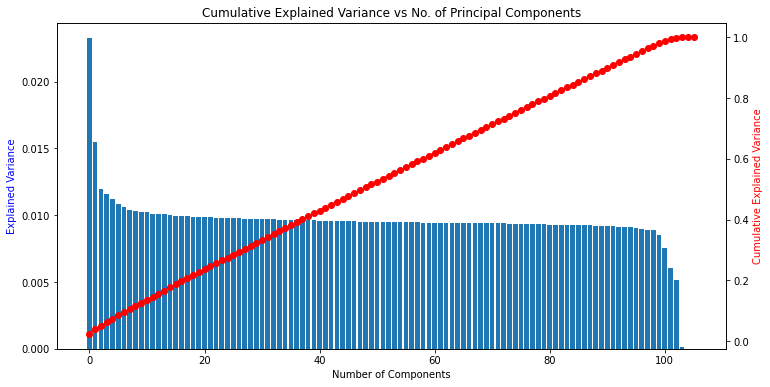

In [133]:
# Investigate the variance accounted for by each principal component.
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(components, pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red", marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")

plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [134]:
pca_50 = PCA(n_components=50).fit(X_scale)

In [135]:
pca_50.explained_variance_ratio_.sum()

0.5082035164796116

#Interpret Principal Components

In [136]:
def get_cpn_feat_wgt(pca, x_scale, cpn_num):
    '''
    Give feature weight of n-th component of pca object
    '''
    weights = pd.DataFrame(np.round(pca.components_, 4),
                           columns=x_scale.columns)
    weight_n = weights.iloc[cpn_num-1, :].sort_values()
    weight_n = weight_n.to_frame()
    weight_n.reset_index(level=0, inplace=True)
    weight_n.columns = ['colname', 'weight']
    return weight_n

In [137]:
def get_top_feature(cpn_feat_wgt, n=5):
    tail_n = cpn_feat_wgt.head(n).reset_index(drop=True)
    head_n = cpn_feat_wgt.tail(n).\
        sort_values(by='weight', ascending=False).reset_index(drop=True)
    top_n = pd.concat([head_n, tail_n], axis=1)
    top_n.columns = ['top_pos_col', 'top_pos_col_wgt',
                     'top_neg_col', 'top_neg_col_wgt']
    return top_n

In [138]:
cpn_wgt_1st = get_cpn_feat_wgt(pca_50, X_scale, 1)
get_top_feature(cpn_wgt_1st, 5).style.\
    bar(subset=['top_pos_col_wgt', 'top_neg_col_wgt'],
        align='mid', color=['#d65f5f', '#5fba7d'])

,top_pos_col,top_pos_col_wgt,top_neg_col,top_neg_col_wgt
0,MG,0.155600,nb_cus_by_state,-0.631100
1,RJ,0.155400,SP,-0.627700
2,RS,0.136000,mean_score,-0.065900
3,PR,0.130900,bed_bath_table,-0.040800
4,BA,0.117400,housewares,-0.037200


In [139]:
X_pca_50 = pca_50.transform(X_scale)

In [140]:
X_pca_50

array([[-2.00475028,  0.36469351,  0.08861452, ..., -0.25613207,
         0.16256893, -0.03094851],
       [-2.00513323, -1.13876453, -0.54972449, ...,  0.00598144,
        -0.01109409, -0.07750586],
       [ 1.5871323 , -0.72705355,  0.60906598, ...,  0.31247742,
        -0.37295836,  0.38806562],
       ...,
       [ 1.75146307, -0.52440924, -0.46255493, ..., -0.93412163,
         0.1538922 , -0.68972109],
       [ 1.59642048, -0.09334591, -1.7817752 , ...,  0.1891265 ,
        -0.03951866,  0.18141627],
       [ 1.39120722, -0.73165488,  0.3708987 , ..., -0.42731245,
        -0.8070329 ,  0.20182912]])

In [141]:
list(X.columns)

['recency',
 'frequency',
 'monetary_value',
 'office_furniture',
 'furniture_decor',
 'furniture_living_room',
 'auto',
 'sports_leisure',
 'baby',
 'housewares',
 'kitchen_dining_laundry_garden_furniture',
 'home_confort',
 'bed_bath_table',
 'home_comfort_2',
 'toys',
 'cool_stuff',
 'computers_accessories',
 'musical_instruments',
 'consoles_games',
 'watches_gifts',
 'perfumery',
 'home_construction',
 'garden_tools',
 'health_beauty',
 'small_appliances',
 'stationery',
 'art',
 'market_place',
 'air_conditioning',
 'telephony',
 'construction_tools_construction',
 'electronics',
 'pet_shop',
 'fixed_telephony',
 'food_drink',
 'drinks',
 'food',
 'fashio_female_clothing',
 'fashion_male_clothing',
 'signaling_and_security',
 'industry_commerce_and_business',
 'construction_tools_lights',
 'agro_industry_and_commerce',
 'diapers_and_hygiene',
 'audio',
 'home_appliances',
 'fashion_bags_accessories',
 'construction_tools_safety',
 'luggage_accessories',
 'fashion_shoes',
 'books_

In [142]:
X_red = pd.concat([X_scale[["recency",	"frequency",	"monetary_value", 'nb_prod_by_cus', 'nb_cus_by_state']], X_scale.loc[:, 'SP':'AC']], axis=1)

In [143]:
X_red

,recency,frequency,monetary_value,nb_prod_by_cus,nb_cus_by_state,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,RN,TO,MA,GO,PI,PE,DF,PB,AL,SE,RO,AC
0000366f3b9a7992bf8c76cfdf3221e2,-0.827609,-0.161147,0.381845,-0.281089,1.151873,1.176907,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.808019,-0.161147,-1.623017,-0.281089,1.151873,1.176907,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
0000f46a3911fa3c0805444483337064,1.954214,-0.161147,-0.284350,-0.281089,-1.019635,-0.849685,-0.099694,-0.24112,-0.384513,5.119650,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
0000f6ccb0745a6a4b88665a16c9f078,0.543712,-0.161147,-1.298671,-0.281089,-1.172023,-0.849685,10.030676,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
0004aac84e0df4da2b147fca70cf8255,0.328219,-0.161147,0.726749,-0.281089,1.151873,1.176907,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.366505,-0.161147,3.026699,0.894581,-1.134531,-0.849685,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,7.632416,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
fffea47cd6d3cc0a88bd621562a9d061,0.158436,-0.161147,-0.348750,-0.281089,-1.032165,-0.849685,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,5.315007,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
ffff371b4d645b6ecea244b27531430a,2.156647,-0.161147,-0.006282,-0.281089,-1.171443,-0.849685,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,10.406042,-0.188147,-0.145091,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244
ffff5962728ec6157033ef9805bacc48,-0.775368,-0.161147,0.253229,-0.281089,-1.112616,-0.849685,-0.099694,-0.24112,-0.384513,-0.195326,-0.364213,-0.096098,-0.188147,6.892211,-0.231137,-0.085256,-0.117852,-0.070472,-0.053445,-0.087257,-0.143402,-0.071155,-0.131020,-0.148566,-0.073603,-0.064928,-0.059864,-0.049609,-0.028244


5
                       recency frequency monetary_value
                          mean      mean           mean
cluster_appartenance                                   
0                    -0.070597  0.003435      -0.082056
1                     0.061306  0.018933       0.063529
2                     0.040116 -0.010268       0.066808
3                     0.085848  0.008273       0.022627
4                     0.068456 -0.017197       0.024100

6
                       recency frequency monetary_value
                          mean      mean           mean
cluster_appartenance                                   
0                     0.085848  0.008273       0.022627
1                     0.061364  0.018173       0.063371
2                     0.032835 -0.003050       0.024238
3                    -0.070597  0.003435      -0.082056
4                     0.033445 -0.012364       0.082947
5                     0.048719 -0.014050       0.078541

7
                       recency frequency

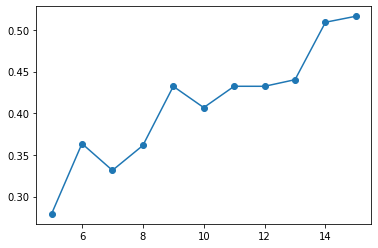

In [144]:
# Search for the optimal hyperparameter k
silhouettes = []
sum_mean_square_distances = []
interval = range(5, 16)
for num_clusters in interval:
    print(num_clusters)
    cls = KMeans(n_clusters=num_clusters)
    cls.fit(X_red)
    X1 = X_red.copy()
    X1["cluster_appartenance"] = cls.labels_
    stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]].agg([np.mean])
    print(stats1)
    print("")
    score = metrics.silhouette_score(X_red, cls.labels_)
    silhouettes.append(score)
n_clusters = silhouettes.index(max(silhouettes)) + min(interval)

print("Le nombre de clusters optimal est : {}".format(n_clusters))
print("La valeur de la silhouette est de : {}".format(max(silhouettes)))

plt.plot(interval, silhouettes, marker="o")

Variance expliquée par les deux premières composantes : 0.137
Pour n_clusters = 15 , Le score de la silhouette moyenne est : 0.43601435984441334


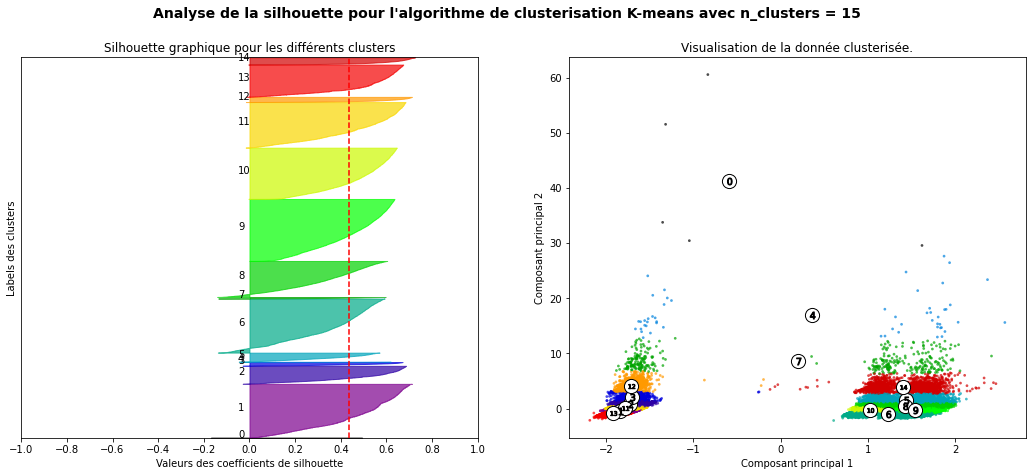

In [145]:
pca = PCA(n_components=2).fit(X_red)
reduced_data = pca.transform(X_red)
print("Variance expliquée par les deux premières composantes : %.3f" \
      % pca.explained_variance_ratio_.cumsum()[1])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# Plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :",
      silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # luster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white",
            alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Composant principal 1")
    ax2.set_ylabel("Composant principal 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means"
                  " avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [146]:
clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(X_red)

In [147]:
X1 = X_red.copy()
X1["cluster_appartenance"] = cluster_labels
stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st1 = stats1.copy()
st1["size"] = X1.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st1

,recency,frequency,monetary_value,size
,mean,mean,mean,
cluster_appartenance,,,,
0,0.037258,-0.161147,-0.003278,10684.0
1,0.192369,-0.018696,0.198406,336.0
2,0.097613,-0.039974,0.250524,474.0
3,-0.069292,4.464995,0.879730,2958.0
4,-0.196805,-0.157128,-0.616499,1191.0
5,-0.067576,-0.161147,-0.115456,38140.0
6,0.036382,-0.051959,0.075214,3200.0
7,0.186028,-0.015739,0.267343,395.0


In [148]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu."
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             ]
clusters = [11, 6, 3, 13, 0, 8, 2]
nb_cust_ = []
for i in clusters:
    nb_cust_.append(st1.loc[i, "size"].values[0])
customer_segment_["segment"] = segment_
customer_segment_["matching_cluster"] = clusters
customer_segment_["number of customers"] = nb_cust_
customer_segment_["segment description"] = description_
customer_segment_["marketing action"] = marketing_

In [149]:
st1.loc[0, "size"].values[0]

10684.0

In [150]:
customer_segment_

,segment,matching_cluster,number of customers,segment description,marketing action
0,Best Customers,11,507.0,"Les clients qui ont acheté le plus récemment, ...","Pas d'incitation aux prix, Nouveaux produits e..."
1,Loyal Customers,6,3200.0,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Dem...
2,Promissing,3,2958.0,"Des acheteurs récents, mais qui n'ont pas beau...",offrir des essais gratuits
3,Big Spenders,13,837.0,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
4,Almost Lost,0,10684.0,"N'ont pas acheté depuis un certain temps, mais...",Offrez d'autres produits pertinents et des rab...
5,Lost Customers,8,709.0,"N'ont pas acheté depuis longtemps, mais ont ac...",Incitations à des prix agressifs
6,Lost Cheap Customers,2,474.0,"Dernier achat il y a longtemps, acheté peu et ...",Ne passez pas trop de temps à essayer de vous ...


# K-means algorithm

In [156]:
population_avg = X[['recency', "frequency", "monetary_value"]].mean()
cluster_avg = X1[['recency', "frequency", "monetary_value", 'cluster_appartenance']].groupby(['cluster_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1

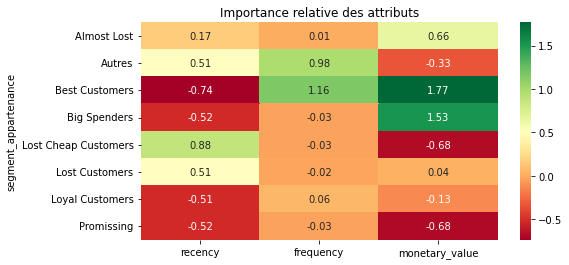

In [153]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

Pour n_clusters = 15 , Le score de la silhouette moyenne est : 0.33466694


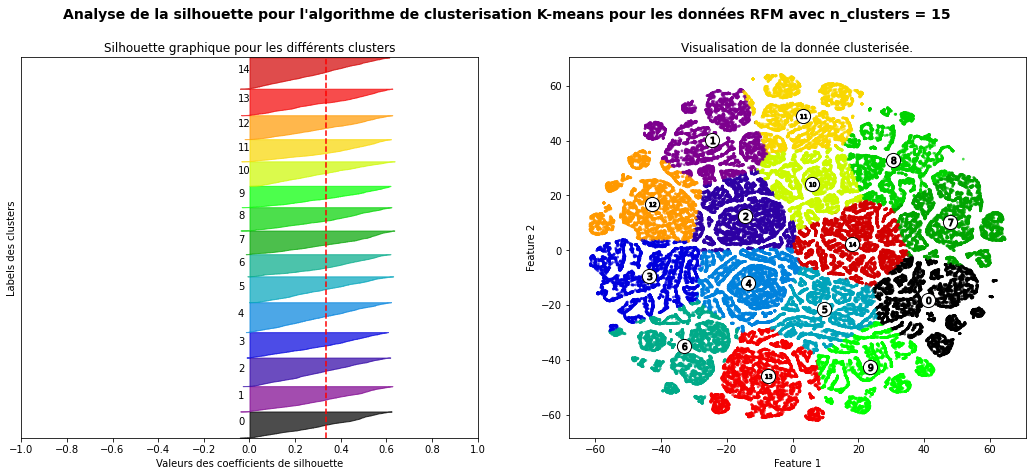

In [154]:
reduced_data = TSNE(n_components=2).fit_transform(X_red)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels2 = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels2)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels2)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels2 == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels2.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [157]:
X2 = X.copy()
X2["cluster_appartenance"] = cluster_labels2
stats2 = X2.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st2 = stats2.copy()
st2["size"] = X2.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st2

,recency,frequency,monetary_value,size
,mean,mean,mean,
cluster_appartenance,,,,
0,327.731348,1.038686,5.005339,6514.0
1,202.058936,1.001917,4.401311,6261.0
2,204.590215,1.007212,4.788850,7072.0
3,285.908035,1.000000,3.134889,6285.0
4,291.411836,1.064181,4.412230,7401.0
5,240.292363,1.000000,4.645945,6403.0
6,246.690228,1.010776,4.566377,5475.0
7,263.494614,1.122072,4.305957,5849.0


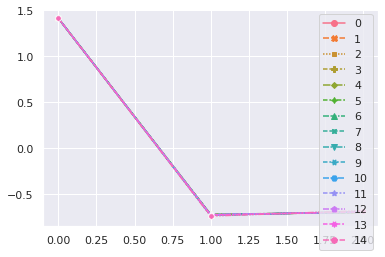

In [158]:
vm = pd.DataFrame(stats2.values.T)
stand = preprocessing.StandardScaler().fit_transform(vm)
sns.set()
sns.lineplot(data=stand, markers=True)

In [159]:
stats2 = stats2.rename(index={0: "best customer", 1: "promissing",
                              2: "Lost customers", 3: "Hibernating"}
                      )
stats2

,recency,frequency,monetary_value
,mean,mean,mean
cluster_appartenance,,,
best customer,327.731348,1.038686,5.005339
promissing,202.058936,1.001917,4.401311
Lost customers,204.590215,1.007212,4.788850
Hibernating,285.908035,1.000000,3.134889
4,291.411836,1.064181,4.412230
5,240.292363,1.000000,4.645945
6,246.690228,1.010776,4.566377
7,263.494614,1.122072,4.305957


In [160]:
population_avg = X.mean()
cluster_avg = X2.groupby(['cluster_appartenance']).mean()
relative_imp2 = cluster_avg / population_avg - 1
relative_imp2 = relative_imp.rename(index={0: "best customer", 1: "promissing",
                                           2: "Lost customers", 3: "Hibernating"}
                                   )

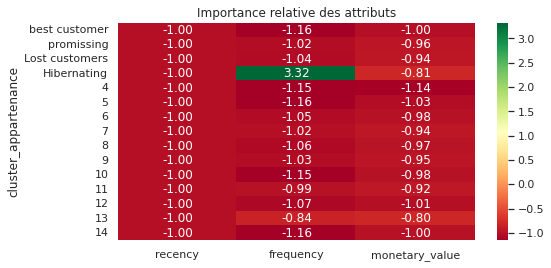

In [161]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp2, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

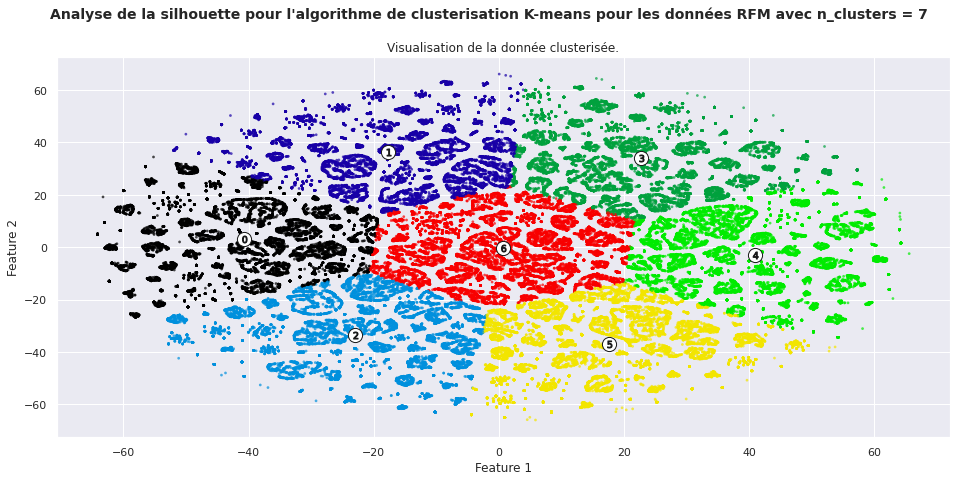

In [162]:
n_clusters_fix = 7
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(16, 7)

clusterer = KMeans(n_clusters=n_clusters_fix, init="random")
cluster_labels2 = clusterer.fit_predict(reduced_data)

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels2.astype(float) / n_clusters_fix)

ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax1.set_title("Visualisation de la donnée clusterisée.")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters_fix
                 ), fontsize=14, fontweight='bold')
plt.show()

In [163]:
X3 = X.copy()
X3["cluster_appartenance"] = cluster_labels2
stats3 = X3.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]].agg([np.mean])
st3 = stats3.copy()
st3["size"] = X3.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st3

,recency,frequency,monetary_value,size
,mean,mean,mean,
cluster_appartenance,,,,
0,251.068575,1.015860,4.613254,13241.0
1,226.516161,1.024335,4.435694,13273.0
2,245.377808,1.014172,4.503590,13266.0
3,253.761280,1.018280,4.421571,12965.0
4,244.351314,1.014865,4.516695,13051.0
5,254.034570,1.031414,4.482616,12988.0
6,227.014303,1.105023,4.617877,15311.0


In [164]:
X3.shape

(94095, 107)

In [165]:
dist = {}
for key, value in cus_id.items(): 
    d = []
    for c in range (0, 7):
        count = 0
        for j, row in X3.iterrows():
            if row["cluster_appartenance"] == c and j in value:
                count += 1
        d.append(count)
    dist[key] = d

In [166]:
dist

{'Almost Lost': [1700, 1373, 1670, 1749, 1525, 1572, 1914],
 'Autres': [30, 47, 31, 40, 21, 84, 242],
 'Best Customers': [30, 66, 29, 42, 33, 56, 236],
 'Big Spenders': [1711, 1641, 1503, 1195, 1453, 1323, 1842],
 'Lost Cheap Customers': [1527, 1676, 1833, 1796, 1794, 1873, 1483],
 'Lost Customers': [3671, 2773, 3270, 3552, 3163, 3403, 3183],
 'Loyal Customers': [1700, 2033, 1539, 1518, 1706, 1563, 2792],
 'Promissing': [2872, 3664, 3391, 3073, 3356, 3114, 3619]}

In [167]:
pd.DataFrame.from_dict(dist)

,Best Customers,Loyal Customers,Promissing,Big Spenders,Almost Lost,Lost Customers,Lost Cheap Customers,Autres
0,30,1700,2872,1711,1700,3671,1527,30
1,66,2033,3664,1641,1373,2773,1676,47
2,29,1539,3391,1503,1670,3270,1833,31
3,42,1518,3073,1195,1749,3552,1796,40
4,33,1706,3356,1453,1525,3163,1794,21
5,56,1563,3114,1323,1572,3403,1873,84
6,236,2792,3619,1842,1914,3183,1483,242


In [168]:
stats3 = stats3.rename(index={0: "Promissing", 1: "Big Spenders",
                              2: "Loyal Customers", 3: "Lost Cheap Customers",
                              4: "Best Customers", 5: "Lost Customers",6: "Almost Lost"
                             }
                      )

In [169]:
stats3

,recency,frequency,monetary_value
,mean,mean,mean
cluster_appartenance,,,
Promissing,251.068575,1.015860,4.613254
Big Spenders,226.516161,1.024335,4.435694
Loyal Customers,245.377808,1.014172,4.503590
Lost Cheap Customers,253.761280,1.018280,4.421571
Best Customers,244.351314,1.014865,4.516695
Lost Customers,254.034570,1.031414,4.482616
Almost Lost,227.014303,1.105023,4.617877


# DBSCAN Algorithm


In [ ]:
sns.set(style="ticks", color_codes=True)
eps = [0.5, 2]
neighs = [3, 5]
silhouettes = []
i = 0
score_max = 0
v_eps = 0
v_neigh = 0
for ep in eps:
    for n in neighs:
        db = DBSCAN(eps=ep, min_samples=n).fit(X_scale)
        score = metrics.silhouette_score(X_scale, db.labels_)
        silhouettes.append(score)
        if i == 0:
            v_eps = ep
            v_neigh = n
            score_max = score
            i += 1
        else:
            if score > score_max:
                v_eps = ep
                v_neigh = n
                score_max = score
print(v_eps)
print(v_neigh)
sns.lineplot(x=eps, y=silhouettes, hue=[3, 5, 3, 5], marker="o")

In [ ]:
v_eps = 1

In [ ]:
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

db = DBSCAN(eps=v_eps, min_samples=10).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(reduced_data, labels))

# Black removed and is used for noise instead.
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 4)
colors = cm.nipy_spectral(labels.astype(float) / n_clusters_)
ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')
plt.show()

# Agglomerative clustering


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X[:1000])
plt.title('Hierarchical Clustering Dendrogram')

# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Nombre de points dans le noeud (ou index de points si aucune parenthèse).")
plt.show()

In [ ]:
clustering = AgglomerativeClustering(n_clusters = 4).fit(X_scale[:1000])
   clustering.labels_[:10]

In [ ]:
len(set(['nama','guy', 'nama']))